In [46]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
class Value:
    
    def __init__(self,data,_children=(), _op='', _label=''):
        self.data = data
        self.grad = 0.00
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self._label = _label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
    
    def __sub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out


    def __pow__(self,other):
        assert isinstance(other,(int,float)),'only supporting int and float values now'
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data **(other - 1)) * out.grad
        out._backward = _backward

        return out
        
    def __rmul__(self,other):
        return self * other

    def __truediv__(self,other):
        return self * other ** -1 

    def __radd__(self,other):
        return self + other

    def tanh(self):
        x= self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    


    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [33]:
import graphviz as g
from graphviz import Digraph
def trace(root):
    nodes,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir':'LR'})
    
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n._label, n.data, n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid  +n._op , uid)

    for n1,n2 in edges: 
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)

    """fie_ext = 'png'
    temp_img = 'temp_file'
    my_graph = g.Source(dot)
    my_graph.render(temp_img,format=fie_ext, view=False)"""
    dot.render('temp_file',format='png',view =True)

    return dot                

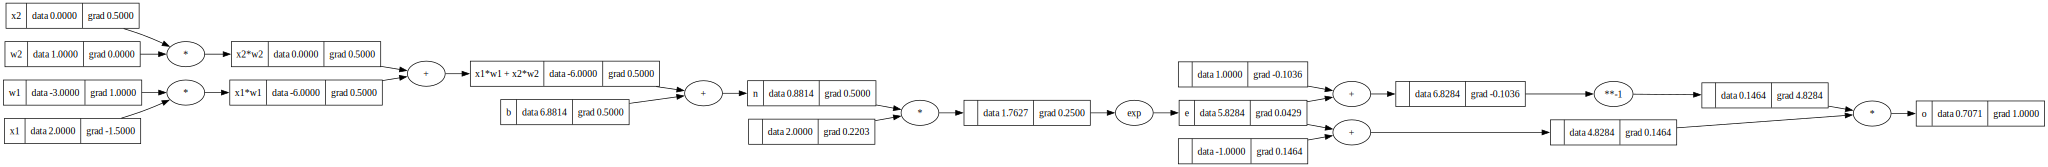

In [47]:
x1 = Value(2.0, _label = 'x1')
x2 = Value(0.0, _label = 'x2')
w1 = Value(-3.0, _label = 'w1')
w2 = Value(1.0, _label = 'w2')
b = Value(6.8813735870195432, _label = 'b')
x1w1 = x1*w1; x1w1._label = 'x1*w1'
x2w2 = x2*w2; x2w2._label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2._label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n._label = 'n'
#---------
e = (2*n).exp(); e._label = 'e'
o = (e - 1)/(e+1)
#---------
o._label = 'o'
o.backward()
draw_dot(o)

In [26]:
import torch

In [44]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('-----')
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7071066904050358
-----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [62]:

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in  range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layers in self.layers for p in layers.parameters()]

In [49]:
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=0.12073585202273289)

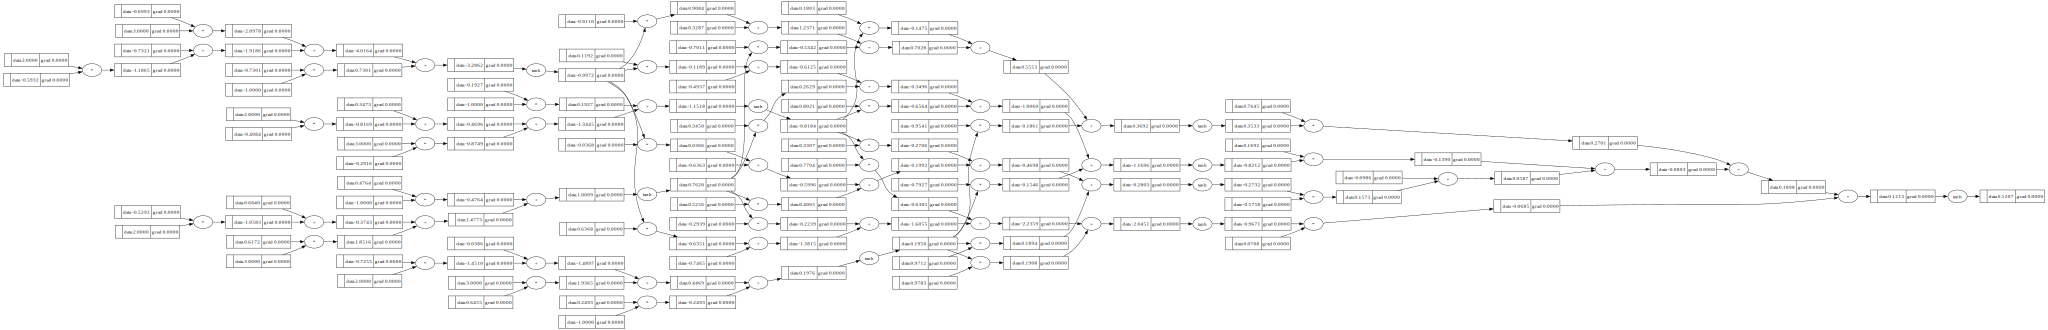

In [50]:
draw_dot(n(x))

In [51]:
xs = [[2.0,3.0,-1.0],
     [3.0,-1.0,0.5],
     [0.5,1.0,1.0],
     [1.0,1.0,-1.0],]
ys = [1.0, -1.0, -1.0, 1.0] #desired target
ypred = [n(x) for x in xs]
ypred

[Value(data=0.12073585202273289),
 Value(data=0.7857236504854932),
 Value(data=-0.3212551693737155),
 Value(data=0.6732382779347625)]

In [52]:
loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))
loss
loss.backward()

In [53]:
n.layers[0].neurons[0].w[0].grad

0.016406559702507484

In [58]:
n.parameters()

[Value(data=-0.5932300099039449),
 Value(data=-0.6992645867200835),
 Value(data=-0.7301483705948086),
 Value(data=-0.732141421211338),
 Value(data=-0.529156489004613),
 Value(data=0.6172051862751222),
 Value(data=0.4764381180502766),
 Value(data=0.684013128123808),
 Value(data=-0.4084476701027395),
 Value(data=-0.2916495418730003),
 Value(data=-0.19269339915619899),
 Value(data=0.34732307235432813),
 Value(data=-0.7255161244820898),
 Value(data=0.6455078699118031),
 Value(data=0.24928221789711102),
 Value(data=-0.03863772806758892),
 Value(data=-0.03675091002818398),
 Value(data=0.5255573284395145),
 Value(data=0.3306635055495819),
 Value(data=0.9711847639163209),
 Value(data=-0.636264637312274),
 Value(data=0.11920070750762557),
 Value(data=0.3450268771020626),
 Value(data=0.8020890417212136),
 Value(data=-0.7926599264206111),
 Value(data=-0.4936614138334505),
 Value(data=-0.9109726695941749),
 Value(data=-0.7011343273265862),
 Value(data=0.18027053436136575),
 Value(data=-0.954060638

In [59]:
n.layers[0].neurons[0].w[0].grad

0.01640655970250748

In [66]:
for k in range(100):

    #forawrd pass
    loss
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt) **2 for ygt, yout in zip(ys, ypred))

    for p in n.parameters():
        p.grad = 0
    loss.backward()

    for p in n.parameters():
        p.data += -0.1 * p.grad
    print(k,loss.data)

0 4.529382165930368
1 4.378714212216391
2 3.7517288944518183
3 3.3520363005452594
4 2.5472179106703248
5 1.8561903036571143
6 1.672921601377499
7 0.9423162070698661
8 0.6110469984837404
9 0.19395496535690127
10 0.15049174490972544
11 0.1276777035152046
12 0.11074934151034056
13 0.0976236263330284
14 0.08716075103566118
15 0.07863684342436444
16 0.07156713115646407
17 0.06561477531995932
18 0.060538644115214785
19 0.05616173131427073
20 0.052351275385398896
21 0.049005820968921296
22 0.046046554926167535
23 0.0434113588060487
24 0.041050635712216337
25 0.0389243247098192
26 0.03699972735991816
27 0.03524990050152786
28 0.033652450794628024
29 0.03218861886403642
30 0.03084257522597629
31 0.029600873144898055
32 0.028452019191696615
33 0.027386133071581522
34 0.02639467586026127
35 0.025470231166513126
36 0.024606327609364556
37 0.02379729381468145
38 0.02303813920785537
39 0.022324455418744588
40 0.021652334269644323
41 0.021018299190707867
42 0.0204192475737745
43 0.019852402088062538


In [68]:
ypred

[Value(data=0.9597941893601378),
 Value(data=-0.9407801478883223),
 Value(data=-0.9814503353717401),
 Value(data=0.953551640429375)]

In [ ]:
# I m proud of myself